# Portfolio Risk Analytics: VaR and ES Estimation


### 1. Overview

This notebook conducts risk analytics framework implementing 17 distinct Value-at-Risk (VaR) and Expected Shortfall (ES) methodologies for portfolio risk measurement.

* Analysis Period: January 1, 2019 - December 22, 2025
* Confidence Level: 99% (α = 0.01)
* Rolling Window: 250 days (~1 year)

###  2. VaR Methodologies 

#### 2.1 Parametric Methods

* Normal Distribution VaR/ES: Assumes Gaussian returns
* Student-t Distribution VaR/ES: Accounts for heavy tails and fat-tail events
* EWMA V* aR: Exponentially weighted moving average (λ = 0.94)
* Cornish-Fisher VaR: Adjusts for skewness and kurtosis

#### 2.2 Non-Parametric Methods

* Historical Simulation VaR/ES: Empirical distribution-based
* Kernel Density Estimation (KDE) VaR/ES: Smoothed continuous distribution


#### 2.3 Advanced Historical Simulation Methods

* Bootstrapped Historical Simulation (BHS): Block bootstrap with 1,000 resamples
* Age-Weighted Historical Simulation (AWHS): Exponential decay (λ = 0.98)
* Volatility-Weighted Historical Simulation (VWHS): Scales by volatility regime
* Correlation-Weighted Historical Simulation (CWHS): Weights by correlation similarity
* Filtered Historical Simulation (FHS): Volatility-adjusted with optional GARCH

#### 2.4 Simulation Methods

* Monte Carlo VaR/ES: 10,000 simulations with normal distribution

## 1. Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm, t as student_t, chi2, gaussian_kde
from datetime import datetime

In [2]:
# --- Install Dependencies ---
import sys
import subprocess
def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])
    
ARCH_AVAILABLE = False
try:
    from arch import arch_model
    ARCH_AVAILABLE = True
except ImportError:
    install('arch ')
    from arch import arch_model
    ARCH_AVAILABLE = True


print(f"'arch' package available:{ARCH_AVAILABLE}. FHS with GARCH will fall back to simple volatility scaling.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 34.3 MB/s eta 0:00:00
'arch' package available:True. FHS with GARCH will fall back to simple volatility scaling.


## 2. Configuration

In [3]:
# Random seed for reproducibility
RANDOM_SEED = 3407
np.random.seed(RANDOM_SEED)

# Date range
START_DATE = "2019-01-01"
END_DATE = datetime.today().strftime("%Y-%m-%d")

# Risk parameters
CONFIDENCE_LEVEL = 0.99
ALPHA = 1 - CONFIDENCE_LEVEL
ROLLING_WINDOW = 250
EWMA_LAMBDA = 0.94

# Bootstrap parameters
N_BOOTSTRAP = 1000
BOOTSTRAP_BLOCK_SIZE = 5

# Portfolio notional amounts
NOTIONAL_BY_TICKER = {
    "ADBE": 18_000, "BALL": 12_000, "DASH": 20_000, "DUK": 12_000,
    "IFF": 15_000, "SO": 20_000, "TJX": 12_000, "UNH": 50_000,
    "AXON": 50_000, "JPM": 18_000, "MAR": 15_000
}
TICKERS = list(NOTIONAL_BY_TICKER.keys())

# Plotting configuration
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print(f"Random seed set to: {RANDOM_SEED}")

Random seed set to: 3407


## 3. Data Acquisition

In [4]:
def download_price_data(tickers, start, end):
    """
    Download and clean adjusted close prices from Yahoo Finance.
    
    Parameters:
        tickers (list): List of ticker symbols
        start (str): Start date in 'YYYY-MM-DD' format
        end (str): End date in 'YYYY-MM-DD' format
    
    Returns:
        pd.DataFrame: Cleaned price data
    """
    if not tickers:
        raise ValueError("Ticker list cannot be empty")
    
    raw = yf.download(tickers, start=start, end=end, progress=False)
    
    if raw.empty:
        raise ValueError("No data downloaded. Check tickers and date range")
    
    if isinstance(raw.columns, pd.MultiIndex):
        prices = raw["Adj Close"] if "Adj Close" in raw.columns.get_level_values(0) else raw["Close"]
    else:
        prices = raw["Adj Close"] if "Adj Close" in raw.columns else raw["Close"]
    
    prices = prices.dropna(how="all", axis=0).dropna(how="all", axis=1)
    
    if prices.empty:
        raise ValueError("All price data is missing after cleaning")
    
    print(f" Downloaded {len(prices)} rows for {list(prices.columns)}")
    return prices

## 4. Portfolio Construction

In [5]:
def construct_portfolio(prices, notional_dict):
    """
    Build portfolio positions and compute P&L series.
    
    Parameters:
        prices (pd.DataFrame): Price data
        notional_dict (dict): Notional amounts by ticker
    
    Returns:
        dict: Portfolio data including values, P&L, returns, and positions
    """
    if prices.empty:
        raise ValueError("Price data is empty")
    
    available = [t for t in notional_dict.keys() if t in prices.columns]
    
    if not available:
        raise ValueError("No matching tickers found in price data")
    
    notional = {t: notional_dict[t] for t in available}
    latest_price = prices.iloc[-1][available]
    
    shares = {}
    for t in available:
        if latest_price[t] > 0:
            shares[t] = int(notional[t] / latest_price[t])
        else:
            shares[t] = 0
            print(f"Warning: Zero price for {t}, setting shares to 0")
    
    pos_values = pd.DataFrame({t: shares[t] * prices[t] for t in available})
    portfolio_value = pos_values.sum(axis=1)
    portfolio_pnl = portfolio_value.diff().dropna()
    portfolio_returns = portfolio_value.pct_change().dropna()
    
    print(f"Portfolio value: ${portfolio_value.iloc[-1]:,.0f}")
    print(f"P&L observations: {len(portfolio_pnl)}")
    
    return {
        'pos_values': pos_values,
        'portfolio_value': portfolio_value,
        'pnl': portfolio_pnl,
        'returns': portfolio_returns,
        'shares': shares,
        'tickers': available,
        'prices': prices[available]
    }

## 5. Basic VaR/ES Methods

In [6]:
def validate_data(data, min_observations=10):
    """Validate input data for VaR calculations."""
    if len(data) < min_observations:
        raise ValueError(f"Insufficient data: {len(data)} < {min_observations}")
    if data.isna().all():
        raise ValueError("All data values are NaN")
    return True

def historical_var(data, alpha):
    """
    Non-parametric historical VaR.
    
    Parameters:
        data (pd.Series or np.array): Return or P&L data
        alpha (float): Significance level (e.g., 0.01 for 99% confidence)
    
    Returns:
        float: VaR estimate (positive value representing loss)
    """
    if len(data) == 0:
        return np.nan
    return -np.percentile(data, 100 * alpha)

def historical_es(data, alpha):
    """
    Historical Expected Shortfall (CVaR).
    
    Parameters:
        data (pd.Series or np.array): Return or P&L data
        alpha (float): Significance level
    
    Returns:
        float: ES estimate (positive value representing expected loss in tail)
    """
    if len(data) == 0:
        return np.nan
    
    var = -np.percentile(data, 100 * alpha)
    tail_data = data[data <= -var]
    
    if len(tail_data) == 0:
        return -data.min()
    
    return -tail_data.mean()

def parametric_var_normal(data, alpha):
    """
    Parametric VaR assuming normal distribution.
    
    Parameters:
        data (pd.Series or np.array): Return or P&L data
        alpha (float): Significance level
    
    Returns:
        float: VaR estimate under normality assumption
    """
    if len(data) < 2:
        return np.nan
    
    mu = data.mean()
    sigma = data.std(ddof=1)
    
    if sigma == 0:
        return -mu
    
    return -(mu + norm.ppf(alpha) * sigma)

def parametric_es_normal(data, alpha):
    """
    Parametric ES assuming normal distribution.
    
    Parameters:
        data (pd.Series or np.array): Return or P&L data
        alpha (float): Significance level
    
    Returns:
        float: ES estimate under normality assumption
    """
    if len(data) < 2:
        return np.nan
    
    mu = data.mean()
    sigma = data.std(ddof=1)
    
    if sigma == 0:
        return -mu
    
    z_alpha = norm.ppf(alpha)
    return -(mu - sigma * norm.pdf(z_alpha) / alpha)

def parametric_var_student_t(data, alpha):
    """
    Parametric VaR using Student's t-distribution.
    
    Parameters:
        data (pd.Series or np.array): Return or P&L data
        alpha (float): Significance level
    
    Returns:
        float: VaR estimate under t-distribution
    """
    if len(data) < 3:
        return parametric_var_normal(data, alpha)
    
    try:
        df, loc, scale = student_t.fit(data)
        
        if df <= 0 or scale <= 0:
            return parametric_var_normal(data, alpha)
        
        t_quantile = student_t.ppf(alpha, df)
        return -(loc + t_quantile * scale)
    except:
        return parametric_var_normal(data, alpha)

def parametric_es_student_t(data, alpha):
    """
    Parametric ES using Student's t-distribution.
    
    Parameters:
        data (pd.Series or np.array): Return or P&L data
        alpha (float): Significance level
    
    Returns:
        float: ES estimate under t-distribution
    """
    if len(data) < 3:
        return parametric_es_normal(data, alpha)
    
    try:
        df, loc, scale = student_t.fit(data)
        
        if df <= 1 or scale <= 0:
            return parametric_es_normal(data, alpha)
        
        t_alpha = student_t.ppf(alpha, df)
        pdf_t = student_t.pdf(t_alpha, df)
        cdf_t = alpha
        
        es = loc - scale * (pdf_t / cdf_t) * ((df + t_alpha**2) / (df - 1))
        return -es
    except:
        return parametric_es_normal(data, alpha)

def ewma_variance(data, lambda_param):
    """
    Compute EWMA variance series.
    
    Parameters:
        data (pd.Series): Return data
        lambda_param (float): Decay factor (typically 0.94)
    
    Returns:
        np.array: EWMA volatility series
    """
    if len(data) == 0:
        return np.array([])
    
    var = np.zeros(len(data))
    var[0] = data.iloc[0]**2 if len(data) > 0 else 0
    
    for i in range(1, len(data)):
        var[i] = lambda_param * var[i-1] + (1 - lambda_param) * data.iloc[i]**2
    
    return np.sqrt(var)

def ewma_var(data, alpha, lambda_param, window):
    """
    Rolling EWMA VaR.
    
    Parameters:
        data (pd.Series): Return or P&L data
        alpha (float): Significance level
        lambda_param (float): EWMA decay factor
        window (int): Rolling window size
    
    Returns:
        pd.Series: EWMA VaR series
    """
    var_series = pd.Series(index=data.index, dtype=float)
    
    for i in range(window, len(data)):
        window_data = data.iloc[i-window:i]
        
        if len(window_data) < window // 2:
            continue
        
        sigma = ewma_variance(window_data, lambda_param)[-1]
        mu = window_data.mean()
        
        var_series.iloc[i] = -(mu + norm.ppf(alpha) * sigma)
    
    return var_series

def cornish_fisher_var(data, alpha):
    """
    Cornish-Fisher expansion VaR (accounts for skewness and kurtosis).
    
    Parameters:
        data (pd.Series or np.array): Return or P&L data
        alpha (float): Significance level
    
    Returns:
        float: Cornish-Fisher adjusted VaR
    """
    if len(data) < 4:
        return parametric_var_normal(data, alpha)
    
    mu = data.mean()
    sigma = data.std(ddof=1)
    
    if sigma == 0:
        return -mu
    
    skew = data.skew()
    kurt = data.kurtosis()
    
    z = norm.ppf(alpha)
    z_cf = (z + 
            (z**2 - 1) * skew / 6 + 
            (z**3 - 3*z) * kurt / 24 - 
            (2*z**3 - 5*z) * skew**2 / 36)
    
    return -(mu + sigma * z_cf)

## 6. Advanced Historical Simulation Methods

In [7]:
def bootstrapped_historical_var(data, alpha, n_bootstrap=1000, block_size=None, seed=None):
    """
    Bootstrapped Historical Simulation (BHS) VaR.
    
    Parameters:
        data (pd.Series or np.array): Return or P&L data
        alpha (float): Significance level
        n_bootstrap (int): Number of bootstrap samples
        block_size (int, optional): Block size for block bootstrap
        seed (int, optional): Random seed for reproducibility
    
    Returns:
        float: Median of bootstrap VaR estimates
    """
    n = len(data)
    if n == 0:
        return np.nan
    
    # Set local random state
    rng = np.random.RandomState(seed)
    
    var_estimates = []
    data_values = data.values if hasattr(data, 'values') else data
    
    for _ in range(n_bootstrap):
        if block_size is None or block_size >= n:
            sample = rng.choice(data_values, size=n, replace=True)
        else:
            n_blocks = int(np.ceil(n / block_size))
            blocks = []
            for _ in range(n_blocks):
                start_idx = rng.randint(0, n - block_size + 1)
                blocks.append(data_values[start_idx:start_idx + block_size])
            sample = np.concatenate(blocks)[:n]
        
        var_estimates.append(-np.percentile(sample, 100 * alpha))
    
    return np.median(var_estimates)

def bootstrapped_historical_es(data, alpha, n_bootstrap=1000, block_size=None, seed=None):
    """
    Bootstrapped Historical Simulation (BHS) ES.
    
    Parameters:
        data (pd.Series or np.array): Return or P&L data
        alpha (float): Significance level
        n_bootstrap (int): Number of bootstrap samples
        block_size (int, optional): Block size for block bootstrap
        seed (int, optional): Random seed for reproducibility
    
    Returns:
        float: Median of bootstrap ES estimates
    """
    n = len(data)
    if n == 0:
        return np.nan
    
    # Set local random state
    rng = np.random.RandomState(seed)
    
    es_estimates = []
    data_values = data.values if hasattr(data, 'values') else data
    
    for _ in range(n_bootstrap):
        if block_size is None or block_size >= n:
            sample = rng.choice(data_values, size=n, replace=True)
        else:
            n_blocks = int(np.ceil(n / block_size))
            blocks = []
            for _ in range(n_blocks):
                start_idx = rng.randint(0, n - block_size + 1)
                blocks.append(data_values[start_idx:start_idx + block_size])
            sample = np.concatenate(blocks)[:n]
        
        var = -np.percentile(sample, 100 * alpha)
        tail = sample[sample <= -var]
        
        if len(tail) > 0:
            es_estimates.append(-tail.mean())
        else:
            es_estimates.append(-sample.min())
    
    return np.median(es_estimates)

def kde_historical_var(data, alpha, bandwidth='scott', seed=None):
    """
    Non-Parametric Density Estimation Historical Simulation VaR.
    
    Parameters:
        data (pd.Series or np.array): Return or P&L data
        alpha (float): Significance level
        bandwidth (str or float): KDE bandwidth method
        seed (int, optional): Random seed for reproducibility
    
    Returns:
        float: KDE-based VaR estimate
    """
    if len(data) < 10:
        return historical_var(data, alpha)
    
    try:
        # KDE uses random sampling internally for some bandwidth methods
        if seed is not None:
            np.random.seed(seed)
        
        kde = gaussian_kde(data, bw_method=bandwidth)
        
        x_min, x_max = data.min(), data.max()
        if x_min == x_max:
            return -x_min
        
        x_grid = np.linspace(x_min, x_max, 10000)
        pdf = kde.evaluate(x_grid)
        
        dx = x_grid[1] - x_grid[0]
        cdf = np.cumsum(pdf) * dx
        cdf = cdf / cdf[-1]
        
        idx = np.searchsorted(cdf, alpha)
        var = -x_grid[min(idx, len(x_grid) - 1)]
        
        return var
    except:
        return historical_var(data, alpha)

def kde_historical_es(data, alpha, bandwidth='scott', seed=None):
    """
    Non-Parametric Density Estimation Historical Simulation ES.
    
    Parameters:
        data (pd.Series or np.array): Return or P&L data
        alpha (float): Significance level
        bandwidth (str or float): KDE bandwidth method
        seed (int, optional): Random seed for reproducibility
    
    Returns:
        float: KDE-based ES estimate
    """
    if len(data) < 10:
        return historical_es(data, alpha)
    
    try:
        if seed is not None:
            np.random.seed(seed)
        
        kde = gaussian_kde(data, bw_method=bandwidth)
        
        x_min, x_max = data.min(), data.max()
        if x_min == x_max:
            return -x_min
        
        x_grid = np.linspace(x_min, x_max, 10000)
        pdf = kde.evaluate(x_grid)
        
        dx = x_grid[1] - x_grid[0]
        cdf = np.cumsum(pdf) * dx
        cdf = cdf / cdf[-1]
        
        idx = np.searchsorted(cdf, alpha)
        
        if idx < len(x_grid):
            tail_x = x_grid[:idx+1]
            tail_pdf = pdf[:idx+1]
            
            if tail_pdf.sum() > 0:
                tail_pdf = tail_pdf / tail_pdf.sum()
                es = -np.sum(tail_x * tail_pdf)
            else:
                es = -tail_x[0] if len(tail_x) > 0 else -x_grid[0]
        else:
            es = -x_grid[-1]
        
        return es
    except:
        return historical_es(data, alpha)

def age_weighted_historical_var(data, alpha, decay_factor=0.98):
    """
    Age-Weighted Historical Simulation (AWHS) VaR.
    
    Parameters:
        data (pd.Series or np.array): Return or P&L data
        alpha (float): Significance level
        decay_factor (float): Exponential decay factor for weights
    
    Returns:
        float: Age-weighted VaR estimate
    """
    n = len(data)
    if n == 0:
        return np.nan
    
    ages = np.arange(n)[::-1]
    weights = decay_factor ** ages
    weights = weights / weights.sum()
    
    data_values = data.values if hasattr(data, 'values') else data
    sorted_indices = np.argsort(data_values)
    sorted_data = data_values[sorted_indices]
    sorted_weights = weights[sorted_indices]
    
    cumulative_weights = np.cumsum(sorted_weights)
    idx = np.searchsorted(cumulative_weights, alpha)
    
    var = -sorted_data[min(idx, len(sorted_data) - 1)]
    return var

def age_weighted_historical_es(data, alpha, decay_factor=0.98):
    """
    Age-Weighted Historical Simulation (AWHS) ES.
    
    Parameters:
        data (pd.Series or np.array): Return or P&L data
        alpha (float): Significance level
        decay_factor (float): Exponential decay factor for weights
    
    Returns:
        float: Age-weighted ES estimate
    """
    n = len(data)
    if n == 0:
        return np.nan
    
    ages = np.arange(n)[::-1]
    weights = decay_factor ** ages
    weights = weights / weights.sum()
    
    data_values = data.values if hasattr(data, 'values') else data
    sorted_indices = np.argsort(data_values)
    sorted_data = data_values[sorted_indices]
    sorted_weights = weights[sorted_indices]
    
    cumulative_weights = np.cumsum(sorted_weights)
    idx = np.searchsorted(cumulative_weights, alpha)
    
    if idx < len(sorted_data):
        tail_data = sorted_data[:idx+1]
        tail_weights = sorted_weights[:idx+1]
        
        if tail_weights.sum() > 0:
            tail_weights = tail_weights / tail_weights.sum()
            es = -np.sum(tail_data * tail_weights)
        else:
            es = -tail_data[0] if len(tail_data) > 0 else -sorted_data[0]
    else:
        es = -sorted_data[-1]
    
    return es

def volatility_weighted_historical_var(data, alpha, vol_window=20):
    """
    Volatility-Weighted Historical Simulation (VWHS) VaR.
    
    Parameters:
        data (pd.Series): Return or P&L data
        alpha (float): Significance level
        vol_window (int): Window for volatility calculation
    
    Returns:
        float: Volatility-weighted VaR estimate
    """
    if len(data) < vol_window:
        return historical_var(data, alpha)
    
    current_vol = data.tail(vol_window).std(ddof=1)
    historical_vols = data.rolling(window=vol_window, min_periods=vol_window//2).std()
    
    vol_ratio = current_vol / historical_vols
    scaled_returns = data * vol_ratio
    scaled_returns = scaled_returns.dropna()
    
    if len(scaled_returns) == 0:
        return historical_var(data, alpha)
    
    return -np.percentile(scaled_returns, 100 * alpha)

def volatility_weighted_historical_es(data, alpha, vol_window=20):
    """
    Volatility-Weighted Historical Simulation (VWHS) ES.
    
    Parameters:
        data (pd.Series): Return or P&L data
        alpha (float): Significance level
        vol_window (int): Window for volatility calculation
    
    Returns:
        float: Volatility-weighted ES estimate
    """
    if len(data) < vol_window:
        return historical_es(data, alpha)
    
    current_vol = data.tail(vol_window).std(ddof=1)
    historical_vols = data.rolling(window=vol_window, min_periods=vol_window//2).std()
    
    vol_ratio = current_vol / historical_vols
    scaled_returns = data * vol_ratio
    scaled_returns = scaled_returns.dropna()
    
    if len(scaled_returns) == 0:
        return historical_es(data, alpha)
    
    var = -np.percentile(scaled_returns, 100 * alpha)
    tail_data = scaled_returns[scaled_returns <= -var]
    
    if len(tail_data) == 0:
        return -scaled_returns.min()
    
    return -tail_data.mean()

def correlation_weighted_historical_var(returns_matrix, portfolio_weights, alpha, corr_window=60):
    """
    Correlation-Weighted Historical Simulation (CWHS) VaR.
    
    Parameters:
        returns_matrix (pd.DataFrame): Multi-asset returns
        portfolio_weights (np.array): Portfolio weights
        alpha (float): Significance level
        corr_window (int): Window for correlation calculation
    
    Returns:
        float: Correlation-weighted VaR estimate
    """
    n = len(returns_matrix)
    
    if n < corr_window * 2:
        portfolio_returns = returns_matrix.dot(portfolio_weights)
        return historical_var(portfolio_returns, alpha)
    
    current_corr = returns_matrix.tail(corr_window).corr().values
    scenario_weights = []
    
    for i in range(corr_window, n):
        window_data = returns_matrix.iloc[i-corr_window:i]
        hist_corr = window_data.corr().values
        
        distance = np.linalg.norm(current_corr - hist_corr, 'fro')
        weight = np.exp(-distance / 2.0)
        scenario_weights.append(weight)
    
    scenario_weights = np.concatenate([np.zeros(corr_window), scenario_weights])
    
    if scenario_weights.sum() == 0:
        scenario_weights = np.ones_like(scenario_weights)
    
    scenario_weights = scenario_weights / scenario_weights.sum()
    
    portfolio_returns = returns_matrix.dot(portfolio_weights).values
    
    sorted_indices = np.argsort(portfolio_returns)
    sorted_returns = portfolio_returns[sorted_indices]
    sorted_weights = scenario_weights[sorted_indices]
    
    cumulative_weights = np.cumsum(sorted_weights)
    idx = np.searchsorted(cumulative_weights, alpha)
    
    var = -sorted_returns[min(idx, len(sorted_returns) - 1)]
    return var

def correlation_weighted_historical_es(returns_matrix, portfolio_weights, alpha, corr_window=60):
    """
    Correlation-Weighted Historical Simulation (CWHS) ES.
    
    Parameters:
        returns_matrix (pd.DataFrame): Multi-asset returns
        portfolio_weights (np.array): Portfolio weights
        alpha (float): Significance level
        corr_window (int): Window for correlation calculation
    
    Returns:
        float: Correlation-weighted ES estimate
    """
    n = len(returns_matrix)
    
    if n < corr_window * 2:
        portfolio_returns = returns_matrix.dot(portfolio_weights)
        return historical_es(portfolio_returns, alpha)
    
    current_corr = returns_matrix.tail(corr_window).corr().values
    scenario_weights = []
    
    for i in range(corr_window, n):
        window_data = returns_matrix.iloc[i-corr_window:i]
        hist_corr = window_data.corr().values
        distance = np.linalg.norm(current_corr - hist_corr, 'fro')
        weight = np.exp(-distance / 2.0)
        scenario_weights.append(weight)
    
    scenario_weights = np.concatenate([np.zeros(corr_window), scenario_weights])
    
    if scenario_weights.sum() == 0:
        scenario_weights = np.ones_like(scenario_weights)
    
    scenario_weights = scenario_weights / scenario_weights.sum()
    
    portfolio_returns = returns_matrix.dot(portfolio_weights).values
    
    sorted_indices = np.argsort(portfolio_returns)
    sorted_returns = portfolio_returns[sorted_indices]
    sorted_weights = scenario_weights[sorted_indices]
    
    cumulative_weights = np.cumsum(sorted_weights)
    idx = np.searchsorted(cumulative_weights, alpha)
    
    if idx < len(sorted_returns):
        tail_returns = sorted_returns[:idx+1]
        tail_weights = sorted_weights[:idx+1]
        
        if tail_weights.sum() > 0:
            tail_weights = tail_weights / tail_weights.sum()
            es = -np.sum(tail_returns * tail_weights)
        else:
            es = -tail_returns[0] if len(tail_returns) > 0 else -sorted_returns[0]
    else:
        es = -sorted_returns[-1]
    
    return es


def filtered_historical_var_enhanced(data, alpha, filter_window=30, garch_adjust=False):
    """
    Enhanced Filtered Historical Simulation (FHS) VaR.
    
    Parameters:
        data (pd.Series): Return or P&L data
        alpha (float): Significance level
        filter_window (int): Window for volatility estimation
        garch_adjust (bool): Use GARCH(1,1) for volatility (requires 'arch' package)
    
    Returns:
        float: Filtered historical VaR estimate
    """
    if garch_adjust and ARCH_AVAILABLE and len(data) > 100:
        try:
            model = arch_model(data * 100, vol='Garch', p=1, q=1, dist='normal')
            res = model.fit(disp='off', show_warning=False)
            current_vol = res.conditional_volatility.iloc[-1] / 100.0
        except:
            current_vol = data.tail(filter_window).std(ddof=1)
    else:
        current_vol = data.tail(filter_window).std(ddof=1)
    
    historical_vol = data.std(ddof=1)
    
    if historical_vol == 0:
        return historical_var(data, alpha)
    
    scaled_returns = data * (current_vol / historical_vol)
    return -np.percentile(scaled_returns, 100 * alpha)

def filtered_historical_es_enhanced(data, alpha, filter_window=30, garch_adjust=False):
    """
    Enhanced Filtered Historical Simulation (FHS) ES.
    
    Parameters:
        data (pd.Series): Return or P&L data
        alpha (float): Significance level
        filter_window (int): Window for volatility estimation
        garch_adjust (bool): Use GARCH(1,1) for volatility
    
    Returns:
        float: Filtered historical ES estimate
    """
    if garch_adjust and ARCH_AVAILABLE and len(data) > 100:
        try:
            model = arch_model(data * 100, vol='Garch', p=1, q=1, dist='normal')
            res = model.fit(disp='off', show_warning=False)
            current_vol = res.conditional_volatility.iloc[-1] / 100.0
        except:
            current_vol = data.tail(filter_window).std(ddof=1)
    else:
        current_vol = data.tail(filter_window).std(ddof=1)
    
    historical_vol = data.std(ddof=1)
    
    if historical_vol == 0:
        return historical_es(data, alpha)
    
    scaled_returns = data * (current_vol / historical_vol)
    
    var = -np.percentile(scaled_returns, 100 * alpha)
    tail_data = scaled_returns[scaled_returns <= -var]
    
    if len(tail_data) == 0:
        return -scaled_returns.min()
    
    return -tail_data.mean()

## 7. Rolling VaR Calculations

In [8]:
def compute_comprehensive_rolling_var(pnl, returns_matrix, portfolio_weights, 
                                     window, alpha, lambda_ewma, seed=None):
    """
    Compute all VaR and ES methods using rolling windows.
    
    Parameters:
        pnl (pd.Series): Portfolio P&L series
        returns_matrix (pd.DataFrame): Multi-asset returns
        portfolio_weights (np.array): Portfolio weights
        window (int): Rolling window size
        alpha (float): Significance level
        lambda_ewma (float): EWMA decay parameter
        seed (int, optional): Random seed for bootstrap methods
    
    Returns:
        pd.DataFrame: VaR and ES estimates for all methods
    """
    results = pd.DataFrame(index=pnl.index)
    
    print("Computing VaR methods:")
    
    # Non-stochastic methods (no seed needed)
    methods_deterministic = [
        ("Historical VaR", 'hist_var', lambda x: historical_var(x, alpha)),
        ("Historical ES", 'hist_es', lambda x: historical_es(x, alpha)),
        ("Parametric Normal VaR", 'param_norm_var', lambda x: parametric_var_normal(x, alpha)),
        ("Parametric Normal ES", 'param_norm_es', lambda x: parametric_es_normal(x, alpha)),
        ("Parametric Student-t VaR", 'param_t_var', lambda x: parametric_var_student_t(x, alpha)),
        ("Parametric Student-t ES", 'param_t_es', lambda x: parametric_es_student_t(x, alpha)),
        ("Cornish-Fisher VaR", 'cf_var', lambda x: cornish_fisher_var(x, alpha)),
        ("Age-Weighted Historical VaR", 'awhs_var', lambda x: age_weighted_historical_var(x, alpha, decay_factor=0.98)),
        ("Age-Weighted Historical ES", 'awhs_es', lambda x: age_weighted_historical_es(x, alpha, decay_factor=0.98)),
        ("Volatility-Weighted Historical VaR", 'vwhs_var', lambda x: volatility_weighted_historical_var(x, alpha, vol_window=20)),
        ("Volatility-Weighted Historical ES", 'vwhs_es', lambda x: volatility_weighted_historical_es(x, alpha, vol_window=20)),
    ]
    
    for i, (name, col, func) in enumerate(methods_deterministic, 1):
        print(f"  [{i}/17] {name}...")
        try:
            results[col] = pnl.rolling(window, min_periods=window//2).apply(func, raw=False)
        except Exception as e:
            print(f"    Warning: {name} failed: {str(e)}")
            results[col] = np.nan
    
    # Stochastic methods (require seed)
    print(f"  [12/17] Bootstrapped Historical VaR (seed={seed})...")
    try:
        results['bhs_var'] = pnl.rolling(window, min_periods=window//2).apply(
            lambda x: bootstrapped_historical_var(x, alpha, n_bootstrap=N_BOOTSTRAP, 
                                                 block_size=BOOTSTRAP_BLOCK_SIZE, seed=seed), 
            raw=False
        )
    except Exception as e:
        print(f"    Warning: Bootstrapped Historical VaR failed: {str(e)}")
        results['bhs_var'] = np.nan
    
    print(f"  [13/17] Bootstrapped Historical ES (seed={seed})...")
    try:
        results['bhs_es'] = pnl.rolling(window, min_periods=window//2).apply(
            lambda x: bootstrapped_historical_es(x, alpha, n_bootstrap=N_BOOTSTRAP, 
                                                block_size=BOOTSTRAP_BLOCK_SIZE, seed=seed), 
            raw=False
        )
    except Exception as e:
        print(f"    Warning: Bootstrapped Historical ES failed: {str(e)}")
        results['bhs_es'] = np.nan
    
    print(f"  [14/17] KDE Historical VaR (seed={seed})...")
    try:
        results['kde_var'] = pnl.rolling(window, min_periods=window//2).apply(
            lambda x: kde_historical_var(x, alpha, seed=seed), 
            raw=False
        )
    except Exception as e:
        print(f"    Warning: KDE Historical VaR failed: {str(e)}")
        results['kde_var'] = np.nan
    
    print(f"  [15/17] KDE Historical ES (seed={seed})...")
    try:
        results['kde_es'] = pnl.rolling(window, min_periods=window//2).apply(
            lambda x: kde_historical_es(x, alpha, seed=seed), 
            raw=False
        )
    except Exception as e:
        print(f"    Warning: KDE Historical ES failed: {str(e)}")
        results['kde_es'] = np.nan
    
    print("  [16/17] EWMA VaR...")
    try:
        results['ewma_var'] = ewma_var(pnl, alpha, lambda_ewma, window)
    except Exception as e:
        print(f"    Warning: EWMA VaR failed: {str(e)}")
        results['ewma_var'] = np.nan
    
    print("  [17/17] Correlation-Weighted Historical VaR/ES...")
    cwhs_var_series = pd.Series(index=pnl.index, dtype=float)
    cwhs_es_series = pd.Series(index=pnl.index, dtype=float)
    
    for i in range(window, len(returns_matrix)):
        try:
            window_returns = returns_matrix.iloc[i-window:i]
            cwhs_var_series.iloc[i] = correlation_weighted_historical_var(
                window_returns, portfolio_weights, alpha, corr_window=min(60, window//2)
            )
            cwhs_es_series.iloc[i] = correlation_weighted_historical_es(
                window_returns, portfolio_weights, alpha, corr_window=min(60, window//2)
            )
        except Exception as e:
            cwhs_var_series.iloc[i] = np.nan
            cwhs_es_series.iloc[i] = np.nan
    
    results['cwhs_var'] = cwhs_var_series
    results['cwhs_es'] = cwhs_es_series
    
    return results.dropna(how='all')

## 8. Backtesting

In [9]:
def kupiec_test(pnl, var_series, alpha):
    """
    Kupiec Proportion of Failures (POF) test.
    
    Parameters:
        pnl (pd.Series): Actual P&L
        var_series (pd.Series): VaR estimates
        alpha (float): Significance level
    
    Returns:
        dict: Test statistics including breaches, LR statistic, and p-value
    """
    aligned_pnl = pnl.reindex(var_series.index)
    breaches = (aligned_pnl < -var_series).astype(int)
    
    n = len(breaches)
    x = breaches.sum()
    p_hat = x / n if n > 0 else 0
    
    if p_hat == 0 or p_hat == 1 or n == 0 or x == 0:
        return {'n': n, 'breaches': x, 'p_hat': p_hat, 'LR': np.nan, 'p_value': np.nan}
    
    ll1 = (n - x) * np.log(1 - alpha) + x * np.log(alpha)
    ll2 = (n - x) * np.log(1 - p_hat) + x * np.log(p_hat)
    LR = -2 * (ll1 - ll2)
    p_value = 1 - chi2.cdf(LR, df=1)
    
    return {'n': n, 'breaches': x, 'p_hat': p_hat, 'LR': LR, 'p_value': p_value}

def backtest_all_methods(pnl, var_results, alpha):
    """
    Comprehensive backtesting of all VaR methods.
    
    Parameters:
        pnl (pd.Series): Actual P&L
        var_results (pd.DataFrame): VaR estimates from all methods
        alpha (float): Significance level
    
    Returns:
        dict: Backtest results for each method
    """
    backtest_summary = {}
    var_columns = [col for col in var_results.columns if col.endswith('_var')]
    
    for col in var_columns:
        method_name = col.replace('_var', '').upper()
        kupiec = kupiec_test(pnl, var_results[col], alpha)
        backtest_summary[method_name] = kupiec
    
    return backtest_summary

## 9. Visualization

In [10]:
def plot_advanced_hs_comparison(pnl, var_results):
    """
    Compare advanced historical simulation methods.
    
    Parameters:
        pnl (pd.Series): Portfolio P&L
        var_results (pd.DataFrame): VaR estimates
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    hs_methods = {
        'Standard vs Bootstrapped': ['hist_var', 'bhs_var'],
        'Standard vs KDE': ['hist_var', 'kde_var'],
        'Standard vs Age-Weighted': ['hist_var', 'awhs_var'],
        'Standard vs Volatility-Weighted': ['hist_var', 'vwhs_var']
    }
    
    for idx, (title, method_list) in enumerate(hs_methods.items()):
        ax = axes[idx // 2, idx % 2]
        
        for method in method_list:
            if method in var_results.columns:
                label = method.replace('_var', '').upper()
                ax.plot(var_results.index, var_results[method], 
                       label=label, alpha=0.7, linewidth=1.5)
        
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
        ax.set_ylabel('VaR ($)')
        ax.set_xlabel('Date')
    
    plt.tight_layout()
    plt.savefig('advanced_hs_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved: advanced_hs_comparison.png")

def plot_var_heatmap(var_results):
    """
    Heatmap showing VaR estimates across methods and time.
    
    Parameters:
        var_results (pd.DataFrame): VaR estimates
    """
    var_cols = [col for col in var_results.columns if col.endswith('_var')]
    
    sampled = var_results[var_cols].iloc[::10].T
    
    plt.figure(figsize=(16, 8))
    plt.imshow(sampled.values, aspect='auto', cmap='RdYlGn_r', interpolation='nearest')
    plt.colorbar(label='VaR ($)')
    plt.yticks(range(len(var_cols)), [col.replace('_var', '').upper() for col in var_cols])
    plt.xlabel('Time (sampled every 10 observations)')
    plt.title('VaR Estimates Across Methods and Time', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('var_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved: var_heatmap.png")

def create_method_comparison_table(var_results):
    """
    Create summary statistics table for all methods.
    
    Parameters:
        var_results (pd.DataFrame): VaR estimates
    
    Returns:
        pd.DataFrame: Summary statistics
    """
    var_cols = [col for col in var_results.columns if col.endswith('_var')]
    
    summary_data = []
    for col in var_cols:
        if col in var_results.columns and not var_results[col].isna().all():
            summary_data.append({
                'Method': col.replace('_var', '').upper(),
                'Mean': var_results[col].mean(),
                'Std': var_results[col].std(),
                'Min': var_results[col].min(),
                'Max': var_results[col].max(),
                'Latest': var_results[col].iloc[-1]
            })
    
    summary = pd.DataFrame(summary_data)
    return summary.sort_values('Mean', ascending=False)

## 10. Analysis Pipeline

In [11]:
def analysis_pipeline(seed=RANDOM_SEED):
    """
    Main analysis pipeline executing all steps.
    
    Parameters:
        seed (int): Random seed for reproducibility
    
    Returns:
        tuple: (portfolio, var_results, backtest_results, comparison_table)
    """
    # Set global random seed
    np.random.seed(seed)
    
    print("=" * 80)
    print("PORTFOLIO RISK ANALYTICS: VaR AND ES ESTIMATION")
    print("=" * 80)
    print(f"Random Seed: {seed}")
    
    print("\n[1/6] Downloading price data...")
    try:
        prices = download_price_data(TICKERS, START_DATE, END_DATE)
    except Exception as e:
        print(f"Error downloading data: {str(e)}")
        return None, None, None, None
    
    print("\n[2/6] Constructing portfolio...")
    try:
        portfolio = construct_portfolio(prices, NOTIONAL_BY_TICKER)
    except Exception as e:
        print(f"Error constructing portfolio: {str(e)}")
        return None, None, None, None
    
    print("\n[3/6] Preparing data for advanced methods...")
    returns_matrix = portfolio['prices'].pct_change().dropna()
    portfolio_value_by_asset = portfolio['pos_values'].iloc[-1]
    total_value = portfolio_value_by_asset.sum()
    portfolio_weights = (portfolio_value_by_asset / total_value).values
    
    print("\n[4/6] Computing comprehensive VaR and ES estimates...")
    print(f"Processing {len(portfolio['pnl'])} observations (this may take several minutes)...")
    
    try:
        var_results = compute_comprehensive_rolling_var(
            portfolio['pnl'],
            returns_matrix,
            portfolio_weights,
            ROLLING_WINDOW,
            ALPHA,
            EWMA_LAMBDA,
            seed=seed
        )
    except Exception as e:
        print(f"Error computing VaR: {str(e)}")
        return portfolio, None, None, None
    
    print("\n[5/6] Backtesting VaR models...")
    try:
        backtest_results = backtest_all_methods(portfolio['pnl'], var_results, ALPHA)
    except Exception as e:
        print(f"Error in backtesting: {str(e)}")
        backtest_results = {}
    
    print("\n" + "=" * 80)
    print("BACKTEST RESULTS (Kupiec POF Test)")
    print("=" * 80)
    
    sorted_results = sorted(backtest_results.items(), 
                          key=lambda x: x[1]['p_hat'] if not np.isnan(x[1]['p_hat']) else 0)
    
    for method, kupiec in sorted_results:
        print(f"\n{method}:")
        print(f"  Observations: {kupiec['n']}")
        print(f"  Breaches: {kupiec['breaches']} ({kupiec['p_hat']:.2%})")
        print(f"  Expected: {ALPHA:.2%}")
        
        if not np.isnan(kupiec['p_value']):
            print(f"  Kupiec LR: {kupiec['LR']:.2f}, p-value: {kupiec['p_value']:.4f}")
            if kupiec['p_value'] < 0.05:
                print(f"  ✗ REJECT - Model underestimates risk")
            else:
                print(f"  ✓ ACCEPT - Model adequate")
        else:
            print(f"  ⚠ Insufficient data for test")
    
    print("\n" + "=" * 80)
    print("METHOD COMPARISON TABLE")
    print("=" * 80)
    
    try:
        comparison_table = create_method_comparison_table(var_results)
        print(comparison_table.to_string(index=False))
    except Exception as e:
        print(f"Error creating comparison table: {str(e)}")
        comparison_table = None
    
    print("\n[6/6] Saving results and generating visualizations...")
    
    try:
        output_df = var_results.copy()
        output_df['pnl'] = portfolio['pnl'].reindex(var_results.index)
        output_df.to_csv('comprehensive_var_results_extended.csv')
        print(f" Saved comprehensive_var_results_extended.csv ({len(output_df)} rows)")
        
        if comparison_table is not None:
            comparison_table.to_csv('method_comparison_summary.csv', index=False)
            print(f" Saved method_comparison_summary.csv")
    except Exception as e:
        print(f"Error saving results: {str(e)}")
    
    try:
        plot_advanced_hs_comparison(portfolio['pnl'], var_results)
        plot_var_heatmap(var_results)
    except Exception as e:
        print(f"Error generating visualizations: {str(e)}")
    
    print("\n" + "=" * 80)
    print("ANALYSIS COMPLETE")
    print("=" * 80)
    print("\nGenerated files:")
    print("  - comprehensive_var_results_extended.csv")
    print("  - method_comparison_summary.csv")
    print("  - advanced_hs_comparison.png")
    print("  - var_heatmap.png")
    
    return portfolio, var_results, backtest_results, comparison_table

PORTFOLIO RISK ANALYTICS: VaR AND ES ESTIMATION
Random Seed: 3407

[1/6] Downloading price data...
 Downloaded 1753 rows for ['ADBE', 'AXON', 'BALL', 'DASH', 'DUK', 'IFF', 'JPM', 'MAR', 'SO', 'TJX', 'UNH']

[2/6] Constructing portfolio...
Portfolio value: $240,761
P&L observations: 1752

[3/6] Preparing data for advanced methods...

[4/6] Computing comprehensive VaR and ES estimates...
Processing 1752 observations (this may take several minutes)...
Computing VaR methods:
  [1/17] Historical VaR...
  [2/17] Historical ES...
  [3/17] Parametric Normal VaR...
  [4/17] Parametric Normal ES...
  [5/17] Parametric Student-t VaR...
  [6/17] Parametric Student-t ES...
  [7/17] Cornish-Fisher VaR...
  [8/17] Age-Weighted Historical VaR...
  [9/17] Age-Weighted Historical ES...
  [10/17] Volatility-Weighted Historical VaR...
  [11/17] Volatility-Weighted Historical ES...
  [12/17] Bootstrapped Historical VaR (seed=3407)...
  [13/17] Bootstrapped Historical ES (seed=3407)...
  [14/17] KDE Histori

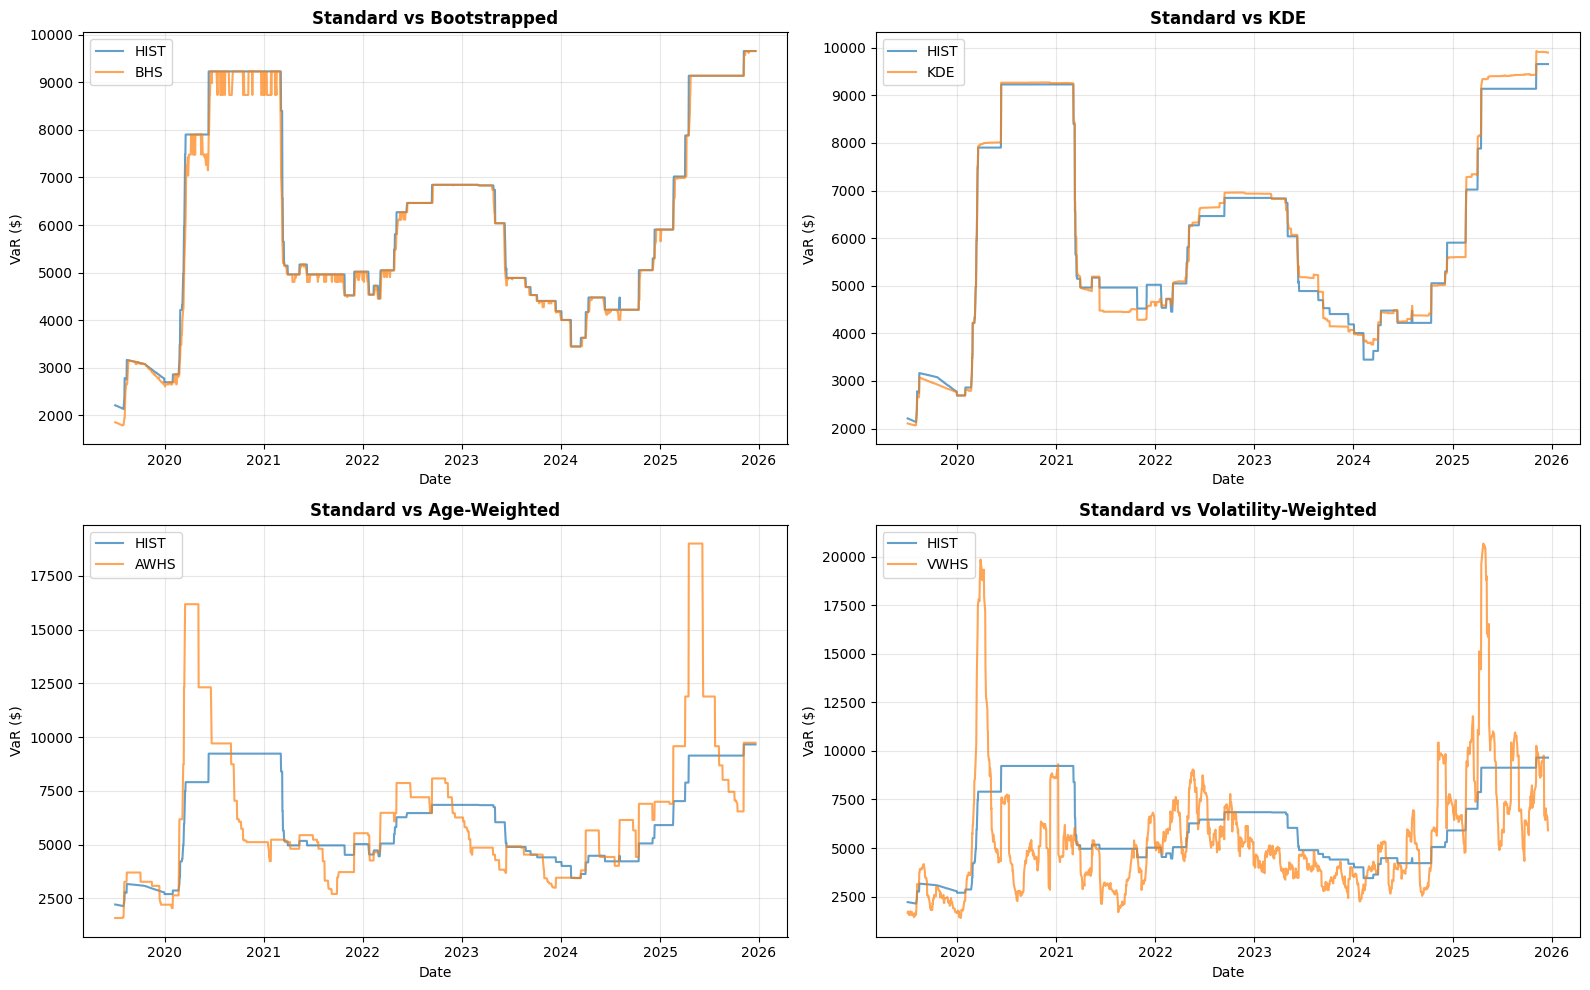

Saved: advanced_hs_comparison.png


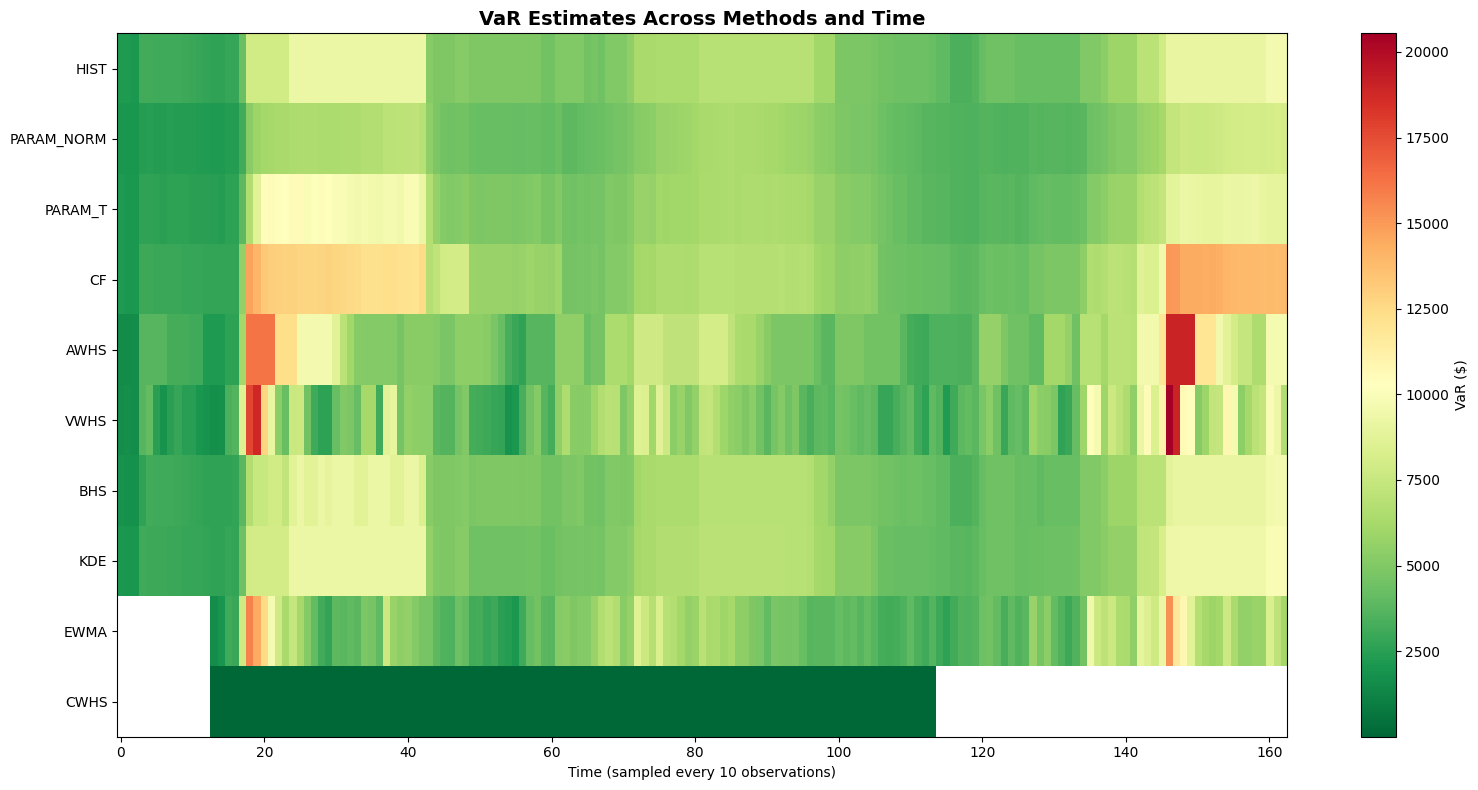

Saved: var_heatmap.png

ANALYSIS COMPLETE

Generated files:
  - comprehensive_var_results_extended.csv
  - method_comparison_summary.csv
  - advanced_hs_comparison.png
  - var_heatmap.png


In [12]:
portfolio, var_results, backtest_results, comparison_table = analysis_pipeline(seed=RANDOM_SEED)

1. https://github.com/aldodec/VaR-Monte-Carlo-Evaluation/tree/master

2. https://github.com/masoomprakhar/Traded-Risk-Analytics/tree/main

3. https://github.com/apexyash27/Stock-Market-Risk-Analysis